Generating a dataset ...
Training ...


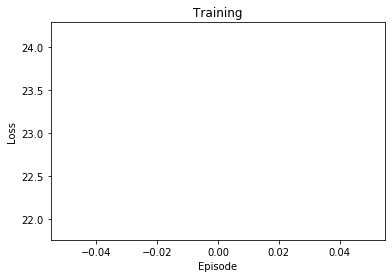




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [29 15  2  3  5  7 31 17 11  0] [29 29 29 29 29 29 29 29 29 29]

Attention matrix


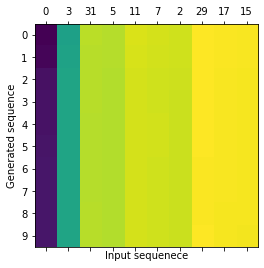


Attention matrix


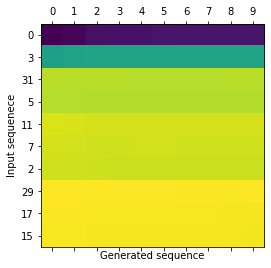

[[-2.728589  -2.4381251 -2.2705545 -2.2746367 -2.2477891 -2.2514858
  -2.2556887 -2.2184756 -2.220777  -2.2228603]
 [-2.720969  -2.4338408 -2.2726915 -2.2753143 -2.2498684 -2.252475
  -2.256256  -2.2186823 -2.221674  -2.2236152]
 [-2.7054574 -2.4302933 -2.2737985 -2.2772756 -2.2516184 -2.2544358
  -2.2579253 -2.2198033 -2.223225  -2.2251902]
 [-2.7031565 -2.4305632 -2.2741158 -2.2778707 -2.251666  -2.2545655
  -2.2588327 -2.2194378 -2.2230666 -2.2250042]
 [-2.7037342 -2.431352  -2.2743115 -2.2778387 -2.251375  -2.2541926
  -2.2591949 -2.2191353 -2.2228146 -2.224699 ]
 [-2.700448  -2.4303484 -2.2748055 -2.2776103 -2.2517383 -2.2543273
  -2.2587442 -2.2200377 -2.223655  -2.2255049]
 [-2.6986475 -2.4298313 -2.2747946 -2.277442  -2.2519555 -2.254475
  -2.2584767 -2.2205095 -2.2242146 -2.2260861]
 [-2.6984966 -2.429849  -2.2744975 -2.2773604 -2.2519853 -2.254538
  -2.25842   -2.220519  -2.2243896 -2.2263072]
 [-2.6985743 -2.4299202 -2.2742672 -2.2773185 -2.2519825 -2.2545707
  -2.2584167 -2

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 30
EPOCHS = 1




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


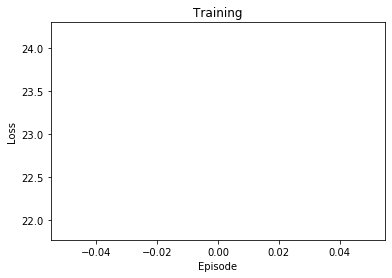




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [31 17 15  7 11  0  3  2  5 29] [0 0 0 0 0 0 0 0 0 0]

Attention matrix


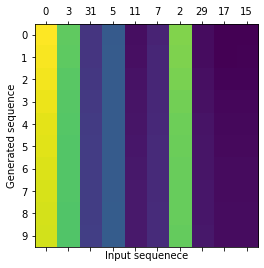


Attention matrix


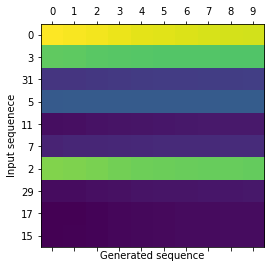

[[-2.052207  -2.1454325 -2.3752844 -2.325758  -2.4202662 -2.3956797
  -2.1238365 -2.4211717 -2.4335299 -2.4337268]
 [-2.0556092 -2.1475306 -2.374908  -2.3243127 -2.4179127 -2.393353
  -2.1254635 -2.4207585 -2.432344  -2.432167 ]
 [-2.0590076 -2.1493473 -2.3726068 -2.324429  -2.415671  -2.3921218
  -2.1291003 -2.4187071 -2.4301991 -2.4299715]
 [-2.0638103 -2.151451  -2.3699307 -2.3243468 -2.4132    -2.390685
  -2.1329868 -2.416006  -2.4275546 -2.4273221]
 [-2.0672202 -2.1527548 -2.367938  -2.324279  -2.4114382 -2.3896813
  -2.1361244 -2.4140444 -2.4256423 -2.425421 ]
 [-2.0699825 -2.1535618 -2.366539  -2.3240979 -2.4101396 -2.3888798
  -2.1383233 -2.4126928 -2.424278  -2.4240503]
 [-2.0724928 -2.1541567 -2.365508  -2.3238215 -2.409109  -2.3881755
  -2.1397953 -2.4116783 -2.4232302 -2.422988 ]
 [-2.0747507 -2.1546533 -2.3647213 -2.323519  -2.4082801 -2.387568
  -2.1407595 -2.4108725 -2.4223986 -2.4221432]
 [-2.0766954 -2.1550803 -2.3641176 -2.3232343 -2.40762   -2.3870616
  -2.141381  -2

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 100
EPOCHS = 1




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


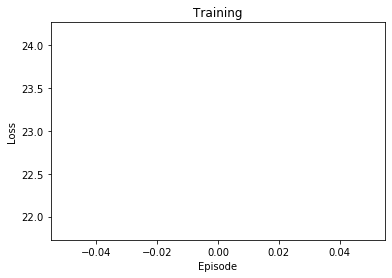




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [ 7 29  5  2  0 15 31 17 11  3] [ 3 15 15 15 31 31 31 31 31 31]

Attention matrix


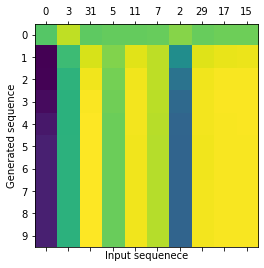


Attention matrix


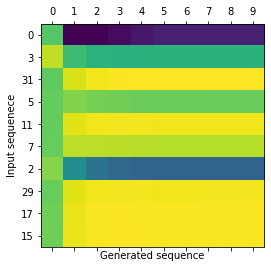

[[-2.323053  -2.2506936 -2.3158152 -2.3112764 -2.3108954 -2.3092513
  -2.2880044 -2.3088446 -2.3050497 -2.3048596]
 [-2.638245  -2.3443518 -2.2364933 -2.2911763 -2.2298295 -2.2535515
  -2.4290383 -2.2301955 -2.2241814 -2.2231545]
 [-2.635808  -2.3621855 -2.2189517 -2.2990217 -2.2193108 -2.252921
  -2.4758544 -2.2197802 -2.2142916 -2.213531 ]
 [-2.6261978 -2.3654187 -2.2127867 -2.3025024 -2.217291  -2.2541933
  -2.4919457 -2.217645  -2.2128007 -2.212164 ]
 [-2.6100633 -2.3647165 -2.2105575 -2.3055255 -2.2181575 -2.2566316
  -2.49936   -2.2178109 -2.2136617 -2.2131824]
 [-2.6012564 -2.3625965 -2.2106605 -2.3068378 -2.2195477 -2.2582045
  -2.499714  -2.2186031 -2.2148721 -2.2145078]
 [-2.600507  -2.3626037 -2.2103906 -2.307062  -2.219633  -2.2584097
  -2.500035  -2.2185106 -2.2149227 -2.2145946]
 [-2.6004753 -2.3626623 -2.210234  -2.3071296 -2.219626  -2.2584581
  -2.50019   -2.218431  -2.2149103 -2.2145982]
 [-2.6004062 -2.3626914 -2.2101474 -2.30717   -2.2196229 -2.2584867
  -2.5002947 

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 250
EPOCHS = 1




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


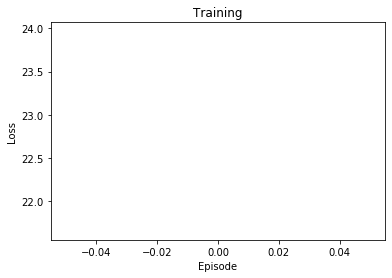




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [ 2  0 17  5  7 29 31 11  3 15] [ 0  0  2 29 29 29 29 29 29 29]

Attention matrix


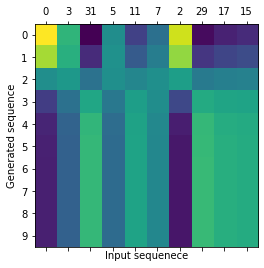


Attention matrix


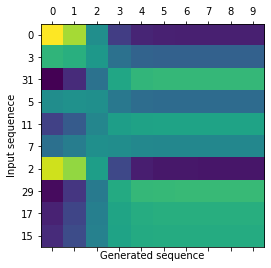

[[-1.6214857 -2.06534   -2.9125304 -2.2812986 -2.6604602 -2.4354937
  -1.7145603 -2.8771603 -2.7875326 -2.7527952]
 [-1.7965317 -2.0982368 -2.7555394 -2.2599583 -2.5425148 -2.36732
  -1.832763  -2.709841  -2.6410751 -2.6128933]
 [-2.275824  -2.2224317 -2.4233825 -2.2710361 -2.320311  -2.2692358
  -2.189557  -2.3781524 -2.3559833 -2.3434784]
 [-2.6774337 -2.4313383 -2.1501532 -2.3937478 -2.1912718 -2.2819362
  -2.6345422 -2.1235874 -2.158276  -2.1641295]
 [-2.7779655 -2.5001779 -2.0646048 -2.453421  -2.168154  -2.3105562
  -2.8059635 -2.0543368 -2.110746  -2.1241972]
 [-2.7949476 -2.5092978 -2.0533342 -2.4612012 -2.1655712 -2.3147979
  -2.8277574 -2.045514  -2.104761  -2.119319 ]
 [-2.7978487 -2.5108995 -2.0513363 -2.4625802 -2.165161  -2.3155987
  -2.8314857 -2.0439906 -2.103738  -2.1184986]
 [-2.798243  -2.5113862 -2.0508435 -2.4630322 -2.1650848 -2.315866
  -2.8324208 -2.0435748 -2.1034744 -2.1182885]
 [-2.7983055 -2.51166   -2.0506144 -2.4632878 -2.1650589 -2.3160167
  -2.8328571 -2

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 500
EPOCHS = 1




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


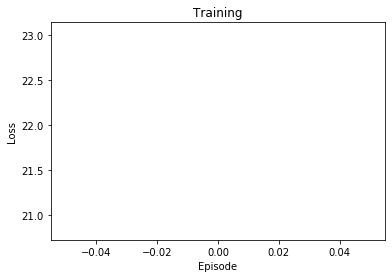




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [15 11  7 29 31  0  2  5 17  3] [ 2  5  7 29 29 31 31 31 31 31]

Attention matrix


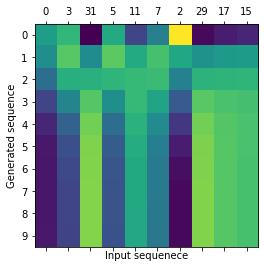


Attention matrix


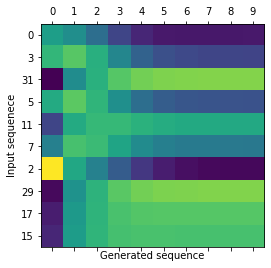

[[-2.5982895  -2.113377   -5.343981   -2.3536582  -4.3175507  -3.2174811
  -0.46028662 -5.2252083  -4.9472475  -4.8284616 ]
 [-2.9397635  -1.7196856  -2.9648948  -1.6913605  -2.355833   -1.8761964
  -2.4152203  -2.862658   -2.7102065  -2.6423845 ]
 [-3.5886786  -2.266786   -2.250567   -2.1429813  -2.0669646  -2.0085359
  -3.2005832  -2.179912   -2.1648622  -2.1475804 ]
 [-4.3145084  -3.0966136  -1.7453842  -2.906842   -2.0795617  -2.494495
  -3.9148688  -1.7174373  -1.8582048  -1.9021001 ]
 [-4.8208823  -3.8045359  -1.4988753  -3.5833068  -2.2312298  -2.985044
  -4.553729   -1.4984257  -1.7670286  -1.859678  ]
 [-5.004813   -4.1431684  -1.4111974  -3.908442   -2.326138   -3.2275233
  -4.95085    -1.4232868  -1.7513938  -1.8666483 ]
 [-5.032739   -4.272182   -1.3787372  -4.0366826  -2.3700185  -3.326982
  -5.1395397  -1.3963529  -1.7497665  -1.8745617 ]
 [-5.038424   -4.3145204  -1.3687412  -4.0788393  -2.383163   -3.3580022
  -5.219845   -1.3886487  -1.7494379  -1.8770951 ]
 [-5.0336  

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 1000
EPOCHS = 1




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


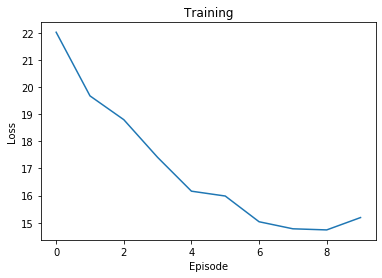




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [ 0  2 15 11 31 17  7 29  5  3] [ 0  2  7 11 11 17 31 29 29 29]

Attention matrix


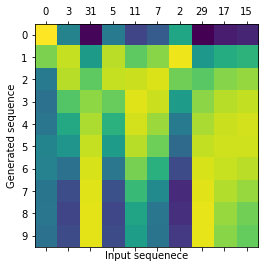


Attention matrix


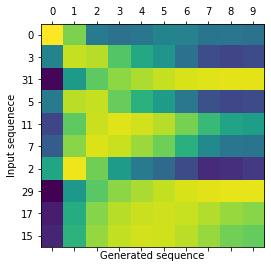

[[-4.1580200e-04 -1.0586607e+01 -1.8867094e+01 -1.1294935e+01
  -1.5076878e+01 -1.3534681e+01 -7.8839417e+00 -1.9091827e+01
  -1.7646578e+01 -1.7125149e+01]
 [-3.7410078e+00 -1.7136621e+00 -8.6807289e+00 -1.9561186e+00
  -4.7338133e+00 -3.4151182e+00 -4.9299049e-01 -8.8771229e+00
  -7.2745810e+00 -6.7308998e+00]
 [-1.1315495e+01 -2.0883417e+00 -4.7078485e+00 -1.6881466e+00
  -1.5116053e+00 -1.0318298e+00 -4.1487732e+00 -4.8573875e+00
  -3.4435196e+00 -2.9998827e+00]
 [-1.1944918e+01 -5.0943980e+00 -3.2442932e+00 -4.4064350e+00
  -9.2984867e-01 -1.5604687e+00 -8.6083012e+00 -3.3497987e+00
  -2.0645914e+00 -1.7379951e+00]
 [-1.1583214e+01 -7.5868878e+00 -2.3191991e+00 -6.8857002e+00
  -1.3165326e+00 -2.8961358e+00 -1.1165546e+01 -2.4084620e+00
  -1.4927573e+00 -1.3390670e+00]
 [-1.0489634e+01 -9.1599255e+00 -1.7109418e+00 -8.5705509e+00
  -2.0740514e+00 -4.2352471e+00 -1.2494043e+01 -1.7769909e+00
  -1.3506155e+00 -1.3839011e+00]
 [-1.0633669e+01 -1.1939804e+01 -1.1459514e+00 -1.1556877e

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 1000
EPOCHS = 10




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


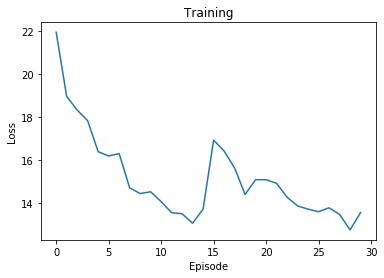




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [17  0 15  2  3 29 31  5  7 11] [ 0  3  7 15 17 17 17 29 29 29]

Attention matrix


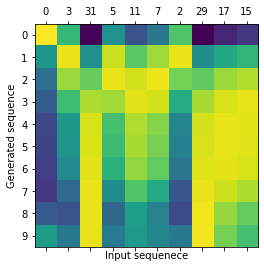


Attention matrix


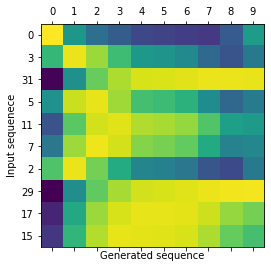

[[-4.19616699e-04 -9.66616631e+00 -2.85378227e+01 -1.42290802e+01
  -2.14193707e+01 -1.74291210e+01 -7.94455910e+00 -2.88373337e+01
  -2.58393154e+01 -2.42151299e+01]
 [-1.35926514e+01 -8.16041946e-01 -1.43547688e+01 -2.28293228e+00
  -7.40802193e+00 -4.23265648e+00 -8.19494247e-01 -1.46961975e+01
  -1.14328308e+01 -9.90435219e+00]
 [-1.83130493e+01 -4.35205460e+00 -6.73336506e+00 -1.12037277e+00
  -1.98793221e+00 -7.58333206e-01 -6.02148056e+00 -6.98463535e+00
  -4.33948708e+00 -3.27149200e+00]
 [-2.03827057e+01 -8.93612194e+00 -3.52827835e+00 -4.07317448e+00
  -1.35019112e+00 -1.85714340e+00 -1.11052532e+01 -3.73838615e+00
  -1.69292641e+00 -1.10747337e+00]
 [-2.26367092e+01 -1.34277086e+01 -1.77157211e+00 -8.55321980e+00
  -3.39196968e+00 -5.38240528e+00 -1.57212610e+01 -1.91575241e+00
  -1.04035950e+00 -1.23463058e+00]
 [-2.29470882e+01 -1.38635101e+01 -1.57889557e+00 -9.07210541e+00
  -3.78848076e+00 -5.88378716e+00 -1.61781998e+01 -1.70633316e+00
  -1.07953453e+00 -1.39842987e+00

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 1000
EPOCHS = 30




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


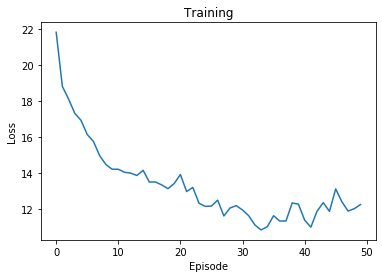




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[ 0  3 31  5 11  7  2 29 17 15] [15  3  0 17  5 11  2 31  7 29] [ 0  2  5  7 11 17 17 31 29 29]

Attention matrix


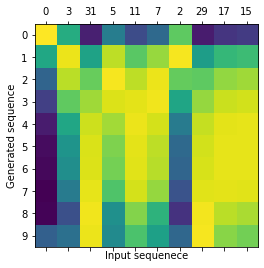


Attention matrix


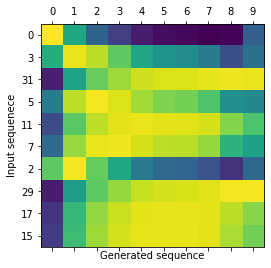

[[-1.33514404e-04 -1.38075695e+01 -3.29608765e+01 -2.07671394e+01
  -2.77801266e+01 -2.37757263e+01 -8.93075180e+00 -3.33640518e+01
  -3.04995060e+01 -2.97771683e+01]
 [-1.45285931e+01 -1.12131119e+00 -1.53570347e+01 -3.65332603e+00
  -9.18985748e+00 -5.60892677e+00 -4.39344406e-01 -1.60153923e+01
  -1.21034641e+01 -1.13090096e+01]
 [-2.44922218e+01 -3.76452446e+00 -8.39951515e+00 -5.11672974e-01
  -3.56299019e+00 -1.07908058e+00 -8.59167862e+00 -8.91015434e+00
  -5.80298615e+00 -5.20234680e+00]
 [-2.93186989e+01 -8.85306740e+00 -5.17670822e+00 -1.87254906e+00
  -1.45258141e+00 -7.54629135e-01 -1.48531590e+01 -5.72464180e+00
  -2.95239639e+00 -2.51515961e+00]
 [-3.33639526e+01 -1.47538176e+01 -2.76886559e+00 -5.06597137e+00
  -1.10708046e+00 -2.34897423e+00 -2.10524044e+01 -3.21001625e+00
  -1.53445435e+00 -1.39014626e+00]
 [-3.49741325e+01 -1.74718456e+01 -2.05732727e+00 -6.94205475e+00
  -1.43789291e+00 -3.54580116e+00 -2.37213497e+01 -2.43936539e+00
  -1.34954071e+00 -1.35328674e+00

In [1]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 1000
EPOCHS = 50




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([0, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()


Generating a dataset ...
Training ...


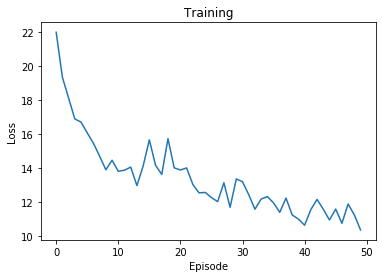




Testing using  a higher length 10
Generating a dataset ...

input	target	pointer
[37  3 31  5 11  7  2 29 17 15] [ 5 29 11  3  7  2 15 17 31 37] [ 2  5 11 17 17 17 17 29 37 37]

Attention matrix


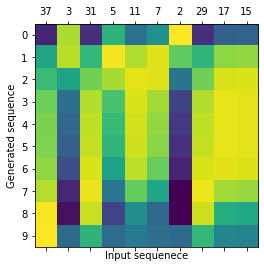


Attention matrix


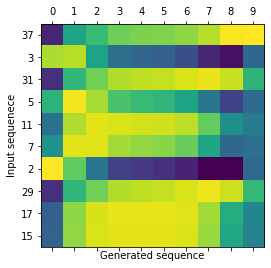

[[-2.48243980e+01 -3.43160629e+00 -2.38986969e+01 -9.75620079e+00
  -1.73377075e+01 -1.36849785e+01 -3.29284668e-02 -2.39063644e+01
  -1.92542362e+01 -1.89181252e+01]
 [-1.15666142e+01 -2.98706818e+00 -9.34124374e+00 -5.21411896e-01
  -3.33654404e+00 -1.20765114e+00 -6.77745628e+00 -9.44437599e+00
  -4.75710487e+00 -4.46375847e+00]
 [-8.83048439e+00 -1.16362648e+01 -5.86114120e+00 -3.62787819e+00
  -1.18927765e+00 -1.34291649e+00 -1.69658279e+01 -5.92313766e+00
  -1.67613411e+00 -1.53652382e+00]
 [-6.11115646e+00 -1.74997044e+01 -3.15921211e+00 -8.00504494e+00
  -1.61537933e+00 -3.81400871e+00 -2.22428112e+01 -3.22584724e+00
  -1.03138924e+00 -1.08506203e+00]
 [-5.49279594e+00 -1.85455036e+01 -2.62023544e+00 -8.96686745e+00
  -1.84763718e+00 -4.46248436e+00 -2.31187096e+01 -2.68680000e+00
  -1.02297211e+00 -1.12023163e+00]
 [-5.37859154e+00 -1.92430573e+01 -2.39913559e+00 -9.60830116e+00
  -2.01083946e+00 -4.89709282e+00 -2.37110043e+01 -2.44588852e+00
  -1.02340508e+00 -1.14835358e+00

In [2]:

""" 
Pointer networks example:

This example shows how to use pointer networks to sort numbers.

"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("../..")

# local files
from seq2seq_with_deep_attention.datasets.SortingDataset import SortingDataset
from seq2seq_with_deep_attention.models.PointerNetwork import PointerNetwork
from seq2seq_with_deep_attention.models.MaskedPointerNetwork import MaskedPointerNetwork

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
IN_FEATURES = 1 # depends on the demnationality of the input
HIDDEN_SIZE = 256
BATCH_SIZE = 64
RANGE = [0, 100] # range of generated numbers in a sequence
SOS_SYMBOL = -1 # start of sequence symbol 
DATASET_SIZE = 1000
EPOCHS = 50




def plot_attention(attention, input_word, generated_word, size_=(10,10),  flipped=False):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    if flipped:
        plt.xlabel('Generated sequence')
        plt.xticks(range(size_[0]), range(len(generated_word)))
        plt.ylabel('Input sequenece')
        plt.yticks(range(size_[1]),input_word)
    else:
        plt.ylabel('Generated sequence')
        plt.yticks(range(size_[0]), range(len(generated_word)))
        plt.xlabel('Input sequenece')
        plt.xticks(range(size_[1]),input_word)
    plt.show(block=False)


def main():

    # dataset generator
    ds = SortingDataset(range_=RANGE, SOS_SYMBOL=SOS_SYMBOL, num_instances=DATASET_SIZE)    
    
    # loaders
    train_dataloader = DataLoader(ds,
                            batch_size=BATCH_SIZE,
                            num_workers=0)


    # The Pointer Network model
                     # use PointerNetwork for an unmasked version
    pointer_network = PointerNetwork(in_features=IN_FEATURES,
                                 hidden_size=HIDDEN_SIZE,
                                 batch_size=BATCH_SIZE,
                                 sos_symbol=SOS_SYMBOL,
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(pointer_network.parameters(), lr=0.0025)

    ################## Training #############
    print('Training ...')
    pointer_network.train()
    epochs_loss = []
    for _ in range(EPOCHS):
        losses = []
        for batch, target_seq in train_dataloader:
            
            # place them in the same device
            batch = batch.to(pointer_network.device)
            target_seq = target_seq.to(pointer_network.device)

            # handel last batch size problem
            last_batch_size, sequence_length = batch.shape
            pointer_network.update_batch_size(last_batch_size)

            # put them in the same device as the model's
            target_seq = target_seq.to(pointer_network.device)

            # zero grad        
            pointer_network.zero_grad()
            pointer_network.encoder.zero_grad()
            pointer_network.decoder_cell.zero_grad()
            batch = batch.unsqueeze(2).float() # add another dim for features 
            
            # apply model
            attentions, pointers = pointer_network(batch)

            # loss calculation
            loss = 0
            # can be replaced by a single elegant line, but I do it like this for better readability
            for i in range(sequence_length):
                loss += loss_function(attentions[:, i, :].to(pointer_network.device), target_seq[:, i])
            #backpropagate
            loss.backward()
            opitmizer.step()
            # loss curve
            losses.append(loss.detach().cpu().item())
            # uncomment this line to store all training tuples
            #samples.append((target_seq.detach().cpu().numpy(), pointers.detach().cpu().numpy()))  
        epochs_loss.append(sum(losses) / len(losses))

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(epochs_loss)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

    ################## Testing #############
    pointer_network.eval() # trun off gradient tracking
    test_sequence_length = 10
    test_batches = 1 # one batch for testing
    print('\n\n\nTesting using  a higher length %d'% test_sequence_length)
    
    ds = SortingDataset(range_=RANGE, lengths=[test_sequence_length], SOS_SYMBOL=SOS_SYMBOL, num_instances=test_batches*last_batch_size)
    test_dataloader = DataLoader(ds,
                            batch_size=last_batch_size,
                            num_workers=0)
    print('\ninput\ttarget\tpointer')
    for batch, target_sequences in test_dataloader:
        batch[0] = torch.tensor([37, 3, 31, 5, 11, 7, 2, 29, 17, 15])
        batch = batch.unsqueeze(2).float().to(pointer_network.device) # add another dim for features 
        attentions, pointers = pointer_network(batch)

        pointers = pointers.detach().cpu().numpy().astype(int)
        input_sequences = batch.squeeze(2).detach().cpu().numpy().astype(int)
        i = 0
        for input_seq, target_seq, pointer in zip(input_sequences, target_sequences, pointers):
            print(input_seq, input_seq[target_seq], input_seq[pointer])
            plot_attention(attentions[i].detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length))
            plot_attention(attentions[i].t().detach().cpu().numpy(), input_seq, input_seq[pointer], size_=(test_sequence_length, test_sequence_length), flipped=True)
            print(attentions[i].detach().cpu().numpy())
            break

            i += 1


if __name__ is '__main__':
    main()
